In [14]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D

# Classification examples - NN classification

In [3]:
ckd = Table().read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


In [4]:
ckd.group('Class') #0 = tha patient has cronic kidney disease

Class,count
0,115
1,43


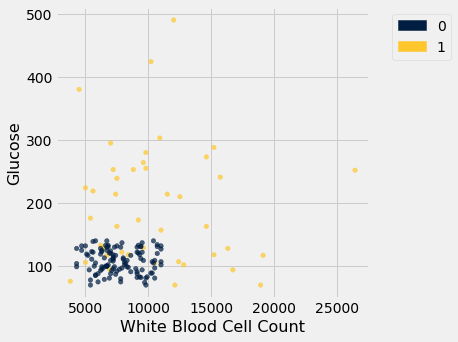

In [7]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors = 'Class')

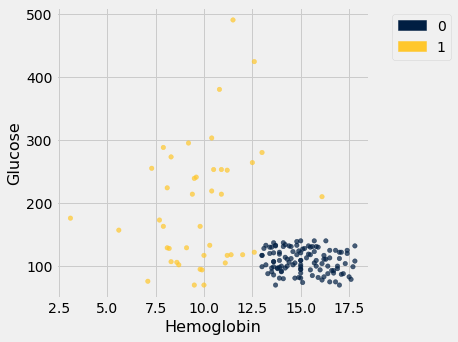

In [8]:
ckd.scatter('Hemoglobin', 'Glucose', colors = 'Class')

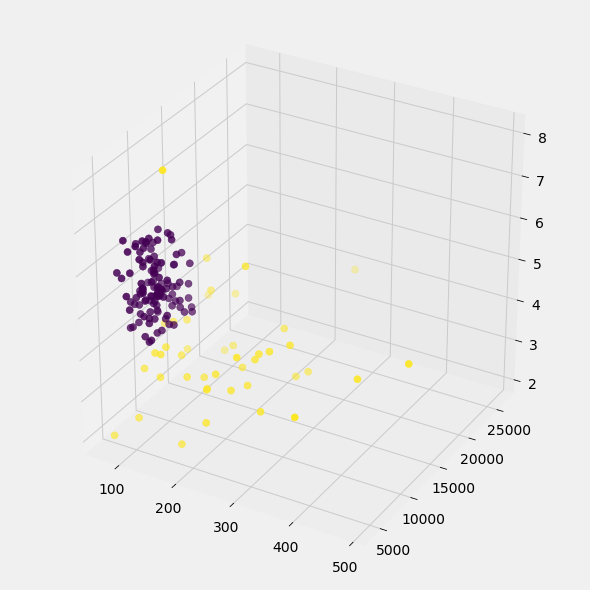

In [15]:
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(ckd.column('Glucose'),
           ckd.column('White Blood Cell Count'),
           ckd.column('Red Blood Cell Count'),
           c = ckd.column('Class'),
           cmap = 'viridis', s = 50);
          

# Building a classifier

In [16]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


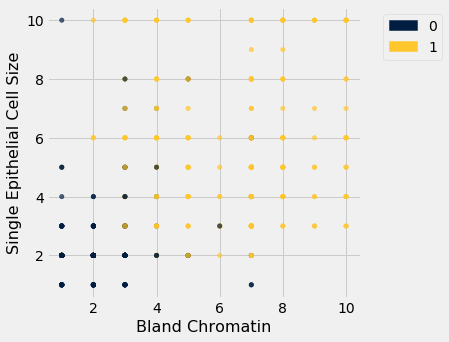

In [19]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', colors='Class') #0 is healthy

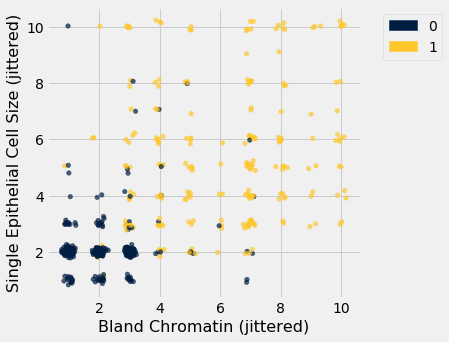

In [18]:
#the visuaization aboave has patients with the same values for the attributes we are seeing
# so the function below adds some noise into drawing those dots to better see the clustering
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter('Bland Chromatin (jittered)', 'Single Epithelial Cell Size (jittered)', colors='Class')

# Distance - computing the similarity between two examples

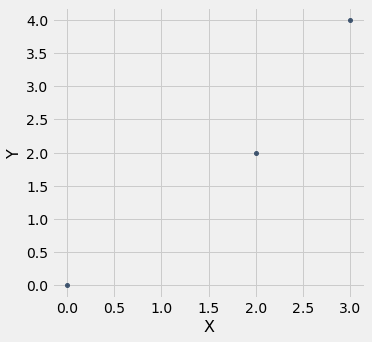

In [21]:
Table().with_columns(['X', [0, 2, 3], 'Y', [0, 2, 4]]).scatter('X', 'Y') 
# t.row(i) - evaluates the ith row of table t
# t.row(i).item(j) - is the value of column j in row i
# np.array(t.row(i)) - evaluates to an array of all the numbers in the row
# ITERATION IN EACH ROW INDIVIDUALLY
# for row in t.rows:
# .....row.item(j)

In [22]:
def distance(pt1, pt2):
    """Return the distance between two points (represented as arrays)"""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [27]:
attributes = patients.drop('Class')
attributes.show(3) #shows the first three row in the table

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [24]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [25]:
row_distance(attributes.row(0), attributes.row(2))

2.23606797749979

In [26]:
row_distance(attributes.row(0), attributes.row(0))

0.0

# Classification Procedure

##The nearest neighbor classifier


In [29]:
def distances(training, example):
    """Compute a table with the training set and distances to the example for each row in the training set."""
    dists = []
    attributes = training.drop('Class')
    for row in attributes.rows:
        dist = row_distance(row, example)
        dists.append(dist)
    return training.with_column('Distance', dists)

In [30]:
def closest(training, example, k):
    """Return a table of the k closest neighbors to example"""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [31]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


In [32]:
example = patients.drop('Class').row(12)
example

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

In [33]:
closest(patients, example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


In [34]:
closest(patients.exclude(12), example, 5)
#excludes the patinet 12 that he kep as a test

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662
4,3,3,1,2,1,3,3,1,0,3.31662


In [38]:
def majority_class(neighbors):
    """Return the class that's most common among all these neighbors."""
    return neighbors.group('Class').sort('count', descending=True).column('Class').item(0)
#shows the first row with the highest

In [39]:
def classify(training, example, k):
    "Return the majority class among the k nearest neighbors."
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [40]:
classify(patients.exclude(12), example, 5)
#shows the class (aka healthy in this case) of the patient 5 based on the nearest neighbor classifier, aka the distance from the attributes calculated above
#so we predict that the patient 12 is a healthy one

0

# Evaluation

In [41]:
patients.num_rows

683

In [42]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [43]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        # Run the classifier on the ith patient in the test set
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            num_correct = num_correct + 1
    return num_correct / test.num_rows

In [44]:
evaluate_accuracy(training_set, test_set, 5)
#the classifier looks at the first cosest 5 patients

0.9794721407624634

In [45]:
evaluate_accuracy(training_set, test_set, 1)
#the cassifier looks at the closest patient 

0.9618768328445748

In [46]:
evaluate_accuracy(training_set, training_set, 1)

1.0

# Decision Boundaries


In [47]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


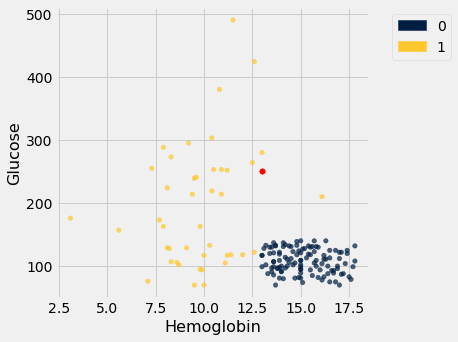

In [48]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter('Hemoglobin', 'Glucose', colors=2)
plots.scatter(13, 250, color='red', s=30);

#the red dot is a new patient inserted in the data set

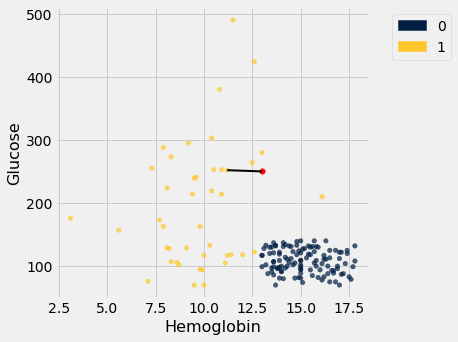

In [49]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)
    
show_closest(kidney, make_array(13, 250))

#the answer is the one showed below because the axes have different units of meaurement
#

In [50]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

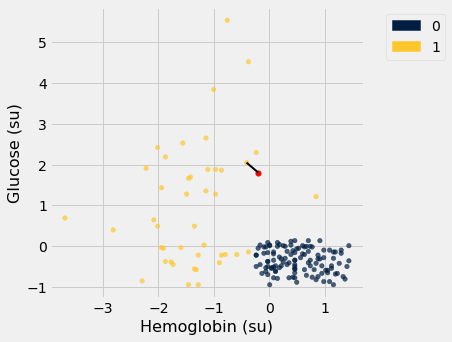

In [51]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))
show_closest(kidney_su, make_array(-0.2, 1.8))

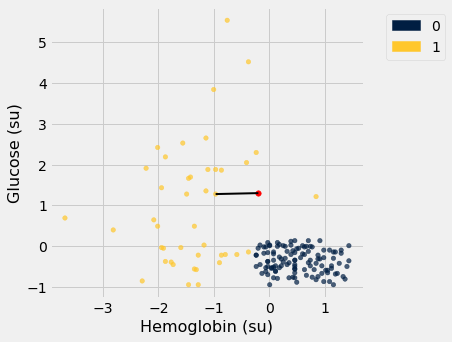

In [52]:
show_closest(kidney_su, make_array(-0.2, 1.3))
#move the red dot below and compare the prediction and so on 

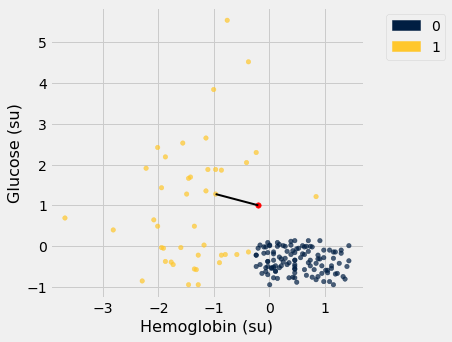

In [53]:
show_closest(kidney_su, make_array(-0.2, 1))

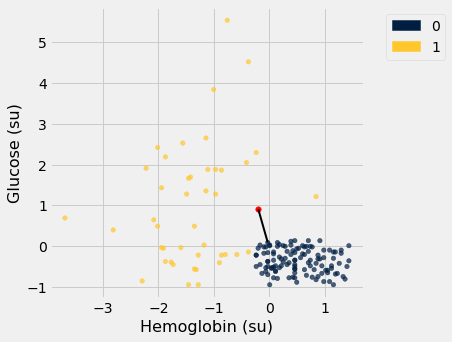

In [54]:
show_closest(kidney_su, make_array(-0.2, 0.9))

# this red point might be at the decision boundary

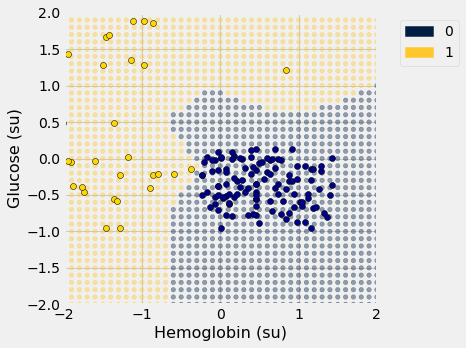

In [55]:
def decision_boundary(t, k):
    """Decision boundary of a two-column + Class table."""
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    decisions = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(-2, 2)
    plots.ylim(-2, 2)
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plots.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plots.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    
decision_boundary(kidney, 1)

#let's imagine every possible place where a new patient could be (all the light dots)
#let's figure out what the classification rule would predict
#draws a blue region that's the entire region for patients that would be healthy
#the decision boundary is the place, the boundary between the regions
#
#

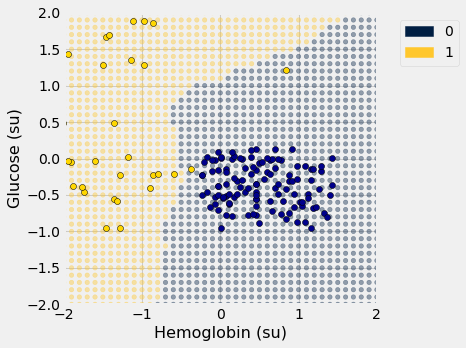

In [56]:
decision_boundary(kidney, 5)
# k = 5

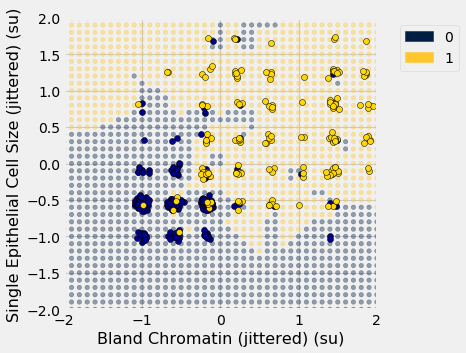

In [57]:
decision_boundary(jittered, 1)

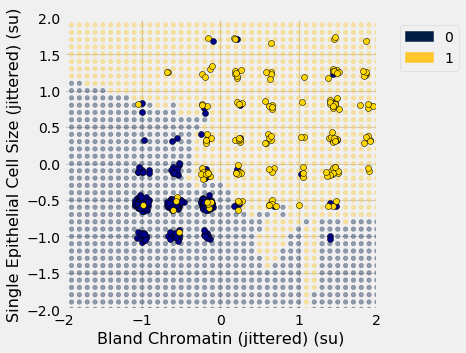

In [58]:
decision_boundary(jittered, 5)